# How to use decision trees to predict equity returns and price moves

In this notebook, we illustrate how to use tree-based models to gain insight and make predictions. 

To demonstrate regression trees we predict returns, and for the classification case, we return to the example of positive and negative asset price moves.

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

import os, sys
from pathlib import Path

import numpy as np
from scipy.stats import spearmanr
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib import cm
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz, _tree
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import roc_auc_score, roc_curve, mean_squared_error, make_scorer
import graphviz

import statsmodels.api as sm

In [3]:
from utils import MultipleTimeSeriesCV

In [4]:
sns.set_style('white')

In [5]:
results_path = Path('results', 'decision_trees')
if not results_path.exists():
    results_path.mkdir(parents=True)

## Load Model Data

We use a simplified version of the data set constructed in Chapter 4, Alpha factor research. It consists of daily stock prices provided by Quandl for the 2010-2017 period and various engineered features. The details can be found in the notebook [data_prep](00_data_prep.ipynb) in the GitHub repo for this chapter.

The decision tree models in this chapter are not equipped to handle missing or categorical variables, so we will apply dummy encoding to the latter after dropping any of the former.

In [6]:
with pd.HDFStore('data.h5') as store:
    data = store['us/Alt_Energy/daily']

    data.index.set_names(["Ticker", "date"], inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5016 entries, ('BE', Timestamp('2019-03-13 00:00:00')) to ('VWSYF', Timestamp('2020-12-30 00:00:00'))
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   dollar_volume  5016 non-null   float64
 1   atr            5016 non-null   float64
 2   bb_down        5016 non-null   float64
 3   bb_high        5016 non-null   float64
 4   bb_low         5016 non-null   float64
 5   bb_mid         5016 non-null   float64
 6   bb_up          5016 non-null   float64
 7   macd           5016 non-null   float64
 8   natr           5016 non-null   float64
 9   rsi            5016 non-null   float64
 10  return_1m      5016 non-null   float64
 11  return_3m      5016 non-null   float64
 12  return_6m      5016 non-null   float64
 13  return_12m     5016 non-null   float64
 14  momentum_3     5016 non-null   float64
 15  momentum_6     5016 non-null   float64
 16  momentum_3_6   501

In [7]:
data.head()

,,dollar_volume,atr,bb_down,bb_high,bb_low,bb_mid,bb_up,macd,natr,rsi,...,return_3m,return_6m,return_12m,momentum_3,momentum_6,momentum_3_6,momentum_12,momentum_3_12,month,target
Ticker,date,,,,,,,,,,,,,,,,,,,,,
BE,2019-03-13,19.570596,0.416073,0.182902,2.873029,2.475257,2.674143,0.214869,0.413793,9.072782,50.304461,...,-0.005712,-0.023019,-0.004334,0.037547,0.020240,-0.017308,0.038925,0.001378,3,-0.055765
BWEN,2019-03-13,0.053295,-0.581117,0.152171,1.041694,0.822389,0.932041,0.067134,0.022268,7.689712,55.906060,...,-0.011835,-0.003984,0.011996,-0.011835,-0.003984,0.007851,0.011996,0.023832,3,0.000000
CSIQ,2019-03-13,24.365068,-0.270088,0.126628,3.290714,3.078555,3.184634,0.085532,0.643142,4.392157,60.168149,...,0.008453,-0.003823,0.000212,0.007184,-0.005092,-0.012276,-0.001058,-0.008242,3,-0.007608
DOGEF,2019-03-13,0.106636,2.331086,0.298246,4.352097,4.047742,4.199920,0.006110,0.852777,10.222203,90.396653,...,0.016024,0.028647,0.017092,0.012128,0.024751,0.012623,0.013196,0.001068,3,0.010349
ENPH,2019-03-13,16.462368,-1.073724,0.247639,2.364287,2.090313,2.227300,0.026335,-0.467674,4.746885,73.817298,...,0.034273,0.012262,0.012539,-0.005727,-0.027738,-0.022011,-0.027461,-0.021734,3,0.002137


## Simple Regression Tree with Time Series Data

Regression trees make predictions based on the mean outcome value for the training samples assigned to a given node and typically rely on the mean-squared error to select optimal rules during recursive binary splitting.

### Generate two lags of monthly returns

In [8]:
X2 = data.loc[:, ['target', 'return_1m']]
X2.columns = ['y', 't-1']
X2['t-2'] = data.groupby(level='Ticker').return_1m.shift()
X2 = X2.dropna()
X2.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5005 entries, ('BE', Timestamp('2019-03-14 00:00:00')) to ('VWSYF', Timestamp('2020-12-30 00:00:00'))
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       5005 non-null   float64
 1   t-1     5005 non-null   float64
 2   t-2     5005 non-null   float64
dtypes: float64(3)
memory usage: 137.8+ KB


In [9]:
y2 = X2.y
X2 = X2.drop('y', axis=1)

### Explore Data

Note the small spike where we clipped the data.

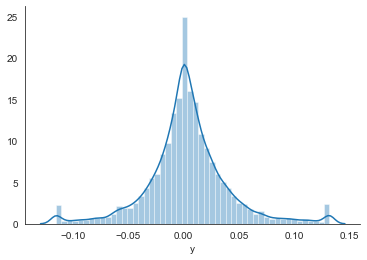

In [10]:
sns.distplot(y2)
sns.despine();

### Configure Tree

Let's start with a simplified example to facilitate visualization and only use two months of lagged returns to predict the following month, in the vein of an AR(2) model from the last chapter:

In [11]:
reg_tree_t2 = DecisionTreeRegressor(criterion='mse',
                                    splitter='best',
                                    max_depth=6,
                                    min_samples_split=2,
                                    min_samples_leaf=50,
                                    min_weight_fraction_leaf=0.0,
                                    max_features=None,
                                    random_state=42,
                                    max_leaf_nodes=None,
                                    min_impurity_decrease=0.0,
                                    min_impurity_split=None,
                                    presort=False)

### Train Decision Tree

In [12]:
%%timeit
reg_tree_t2.fit(X=X2, y=y2)

6.38 ms ± 18.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [13]:
reg_tree_t2.fit(X=X2, y=y2)

DecisionTreeRegressor(max_depth=6, min_samples_leaf=50, presort=False,
                      random_state=42)

### Visualize Tree

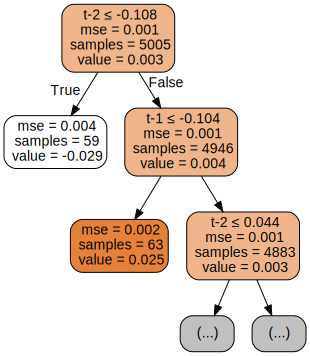

In [14]:
out_file = results_path / 'reg_tree_t2.dot'
dot_data = export_graphviz(reg_tree_t2,
                          out_file=out_file.as_posix(),
                          feature_names=X2.columns,
                          max_depth=2,
                          filled=True,
                          rounded=True,
                          special_characters=True)
if out_file is not None:
    dot_data = Path(out_file).read_text()

graphviz.Source(dot_data)

### Compare with Linear Regression

The OLS summary below and a visualization of the first two levels of the decision tree above reveal the striking differences between the models. The OLS model provides three parameters for the intercepts and the two features in line with the linear assumption.

In contrast, the regression tree chart above displays for each node of the first two levels the feature and threshold used to split the data (note that features can be used repeatedly), as well as the current value of the mean-squared error (MSE), the number of samples, and predicted value based on these training samples.

The tree chart also highlights the uneven distribution of samples across the nodes as the numbers vary between 59 and 5005 samples after only two splits.

#### statsmodels OLS

In [15]:
ols_model = sm.OLS(endog=y2, exog=sm.add_constant(X2))

In [16]:
%%timeit
ols_model.fit()

11.8 µs ± 34.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [17]:
result = ols_model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     12.99
Date:                Thu, 07 Jan 2021   Prob (F-statistic):           2.37e-06
Time:                        12:35:04   Log-Likelihood:                 9375.0
No. Observations:                5005   AIC:                        -1.874e+04
Df Residuals:                    5002   BIC:                        -1.872e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.001      6.066      0.0

#### sklearn Linear Regression

In [18]:
lin_reg = LinearRegression()

In [19]:
%%timeit
lin_reg.fit(X=X2,y=y2)

1.63 ms ± 43.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [20]:
lin_reg.fit(X=X2,y=y2)

LinearRegression()

In [21]:
lin_reg.intercept_

0.003213980640642052

In [22]:
lin_reg.coef_

array([-0.03151099,  0.06356079])

### Linear Regression vs Regression Tree Decision Surfaces

The following figure shows the current period return as a function of returns one and two periods ago for linear regression and the regression tree:

The linear-regression model result on the right side underlines the linearity of the relationship between lagged and current returns, whereas the regression tree chart on the left illustrates the non-linear relationship encoded in the recursive partitioning of the feature space.

In [23]:
t1, t2 = np.meshgrid(np.linspace(X2['t-1'].quantile(.01), X2['t-1'].quantile(.99), 100),
                     np.linspace(X2['t-2'].quantile(.01), X2['t-2'].quantile(.99), 100))
X_data = np.c_[t1.ravel(), t2.ravel()]

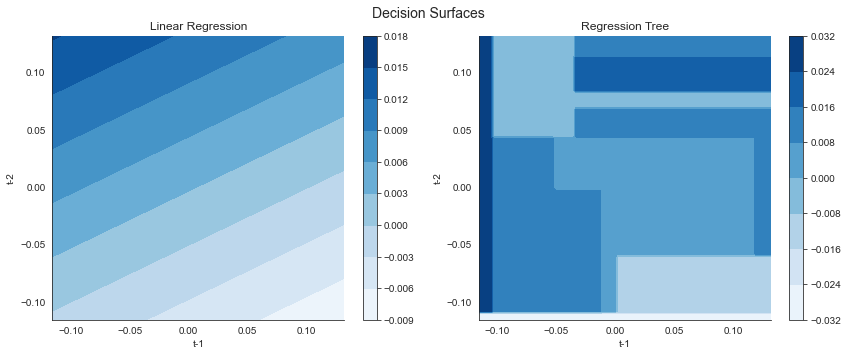

In [24]:
fig, axes = plt.subplots(ncols=2, figsize=(12,5))

# Linear Regression
ret1 = lin_reg.predict(X_data).reshape(t1.shape)
surface1 = axes[0].contourf(t1, t2, ret1, cmap='Blues')
plt.colorbar(mappable=surface1, ax=axes[0])

# Regression Tree
ret2 = reg_tree_t2.predict(X_data).reshape(t1.shape)
surface2 = axes[1].contourf(t1, t2, ret2, cmap='Blues')
plt.colorbar(mappable=surface2, ax=axes[1])

# Format plots
titles = ['Linear Regression', 'Regression Tree']
for i, ax in enumerate(axes):
    ax.set_xlabel('t-1')
    ax.set_ylabel('t-2')
    ax.set_title(titles[i])

fig.suptitle('Decision Surfaces', fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9);

## Simple Classification Tree with Time Series Data

### Configure Tree

In [32]:
clf_tree_t2 = DecisionTreeClassifier(criterion='gini',
                                     splitter='best',
                                     max_depth=5,
                                     min_samples_split=1000,
                                     min_samples_leaf=1,
                                     min_weight_fraction_leaf=0.0,
                                     max_features=None,
                                     random_state=42,
                                     max_leaf_nodes=None,
                                     min_impurity_decrease=0.0,
                                     min_impurity_split=None,
                                     class_weight=None,
                                     presort=False)

### Train Tree

In [33]:
y_binary = (y2>0).astype(int)
y_binary.value_counts()

1    2601
0    2404
Name: y, dtype: int64

In [34]:
%%timeit
clf_tree_t2.fit(X=X2, y=y_binary)

6.51 ms ± 24.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [35]:
clf_tree_t2.fit(X=X2, y=y_binary)

DecisionTreeClassifier(max_depth=5, min_samples_split=1000, presort=False,
                       random_state=42)

### Visualize Tree

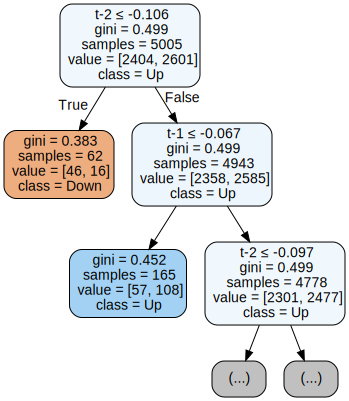

In [36]:
out_file = results_path / 'clf_tree_t2.dot'
dot_data = export_graphviz(clf_tree_t2,
                           out_file=out_file.as_posix(),
                           feature_names=X2.columns,
                           class_names=['Down', 'Up'],
                           max_depth=2,
                           filled=True,
                           rounded=True,
                           special_characters=True)
if out_file is not None:
    dot_data = Path(out_file).read_text()

graphviz.Source(dot_data)

### Compare with Logistic Regression

#### Statsmodels

In [37]:
log_reg_sm = sm.Logit(endog=y_binary, exog=sm.add_constant(X2))

In [38]:
%%timeit
log_reg_sm.fit(disp=False)

1.97 ms ± 100 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [39]:
log_result = log_reg_sm.fit()

Optimization terminated successfully.
         Current function value: 0.691224
         Iterations 4


In [40]:
print(log_result.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 5005
Model:                          Logit   Df Residuals:                     5002
Method:                           MLE   Df Model:                            2
Date:                Thu, 07 Jan 2021   Pseudo R-squ.:                0.001659
Time:                        12:35:53   Log-Likelihood:                -3459.6
converged:                       True   LL-Null:                       -3465.3
Covariance Type:            nonrobust   LLR p-value:                  0.003191
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0804      0.029      2.814      0.005       0.024       0.136
t-1           -1.9899      0.763     -2.609      0.009      -3.485      -0.495
t-2            1.5793      0.763      2.071      0.0

#### sklearn

In [41]:
log_reg_sk = LogisticRegression()

In [42]:
%%timeit
log_reg_sk.fit(X=X2, y=y_binary)

7.44 ms ± 368 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [43]:
log_reg_sk.fit(X=X2, y=y_binary)

LogisticRegression()

In [44]:
log_reg_sk.coef_

array([[-1.27082145,  1.01369926]])

### Decision Surfaces: Classifier Tree vs. Logistic Regression 

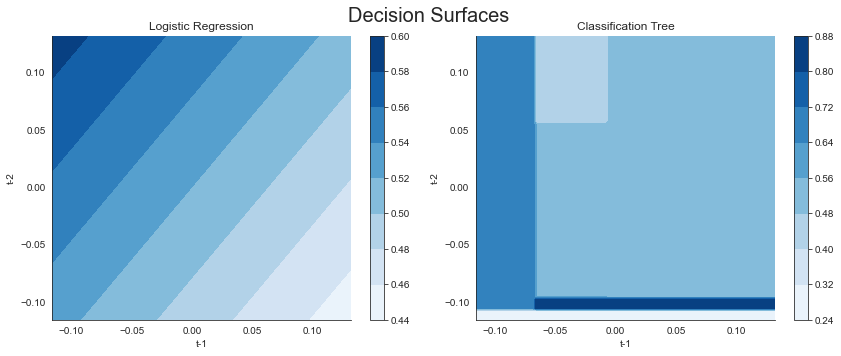

In [45]:
fig, axes = plt.subplots(ncols=2, figsize=(12,5))

# Linear Regression
ret1 = log_reg_sk.predict_proba(X_data)[:, 1].reshape(t1.shape)
surface1 = axes[0].contourf(t1, t2, ret1, cmap='Blues')
plt.colorbar(mappable=surface1, ax=axes[0])

# Regression Tree
ret2 = clf_tree_t2.predict_proba(X_data)[:, 1].reshape(t1.shape)
surface2 = axes[1].contourf(t1, t2, ret2, cmap='Blues')
plt.colorbar(mappable=surface2, ax=axes[1])

# Format plots
titles = ['Logistic Regression', 'Classification Tree']
for i, ax in enumerate(axes):
    ax.set_xlabel('t-1')
    ax.set_ylabel('t-2')
    ax.set_title(titles[i])

fig.suptitle('Decision Surfaces', fontsize=20)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9);

## Regression Tree with all Features

### Train-Test Split

In [46]:
X = pd.get_dummies(data.drop('target', axis=1))
y = data.target

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Configure Tree

The output after training the model displays all the DecisionTreeClassifier parameters that we will address in more detail in the next section when we discuss parameter-tuning. 

In [48]:
regression_tree = DecisionTreeRegressor(criterion='mse',
                                        splitter='best',
                                        max_depth=5,
                                        min_samples_split=2,
                                        min_samples_leaf=1,
                                        min_weight_fraction_leaf=0.0,
                                        max_features=None,
                                        random_state=42,
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        presort=False)

### Train Model

In [49]:
regression_tree.fit(X=X_train, y=y_train)

DecisionTreeRegressor(max_depth=5, presort=False, random_state=42)

### Visualize Tree

The result shows that the model uses a variety of different features and indicates the split rules for both continuous and categorical (dummy) variables. 

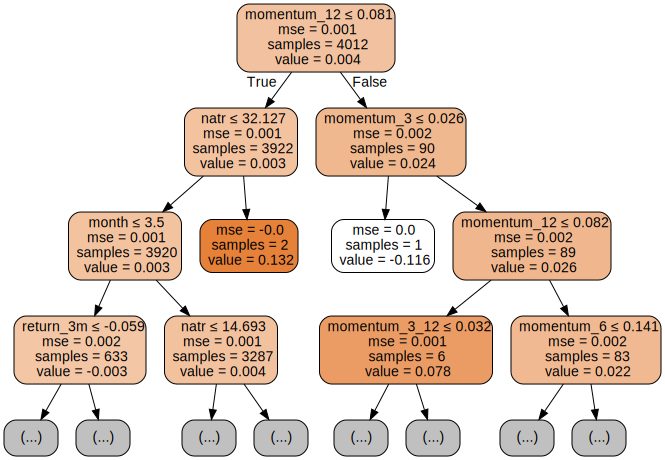

In [50]:
out_file = results_path / 'reg_tree.dot'
dot_data = export_graphviz(regression_tree,
                           out_file=out_file.as_posix(),
                           feature_names=X_train.columns,
                           max_depth=3,
                           filled=True,
                           rounded=True,
                           special_characters=True)
if out_file is not None:
    dot_data = Path(out_file).read_text()

graphviz.Source(dot_data)

### Evaluate Test Set

In [51]:
y_pred = regression_tree.predict(X_test)

In [52]:
np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_test))

0.037522885206168706

In [53]:
r, p = spearmanr(y_pred, y_test)
print(f'{r*100:.2f} (p-value={p:.2%})')

4.92 (p-value=11.93%)


## Classification Tree with all Features

### Train-Test Split

In [54]:
y_binary = (y>0).astype(int)
y_binary.value_counts()

1    2606
0    2410
Name: target, dtype: int64

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42)

In [56]:
clf = DecisionTreeClassifier(criterion='gini',
                             max_depth=5,
                             random_state=42)

In [57]:
clf.fit(X=X_train, y=y_train)

DecisionTreeClassifier(max_depth=5, random_state=42)

### Plot Tree

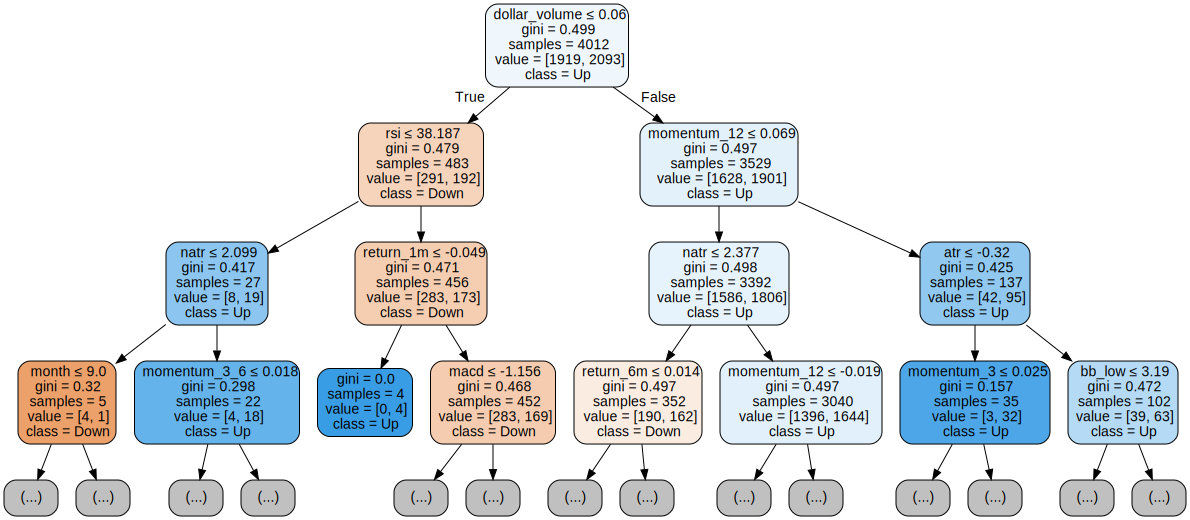

In [58]:
out_file = results_path / 'clf_tree.dot'
dot_data = export_graphviz(clf,
                           out_file=out_file.as_posix(),
                           feature_names=X.columns,
                           class_names=['Down', 'Up'],
                           max_depth=3,
                           filled=True,
                           rounded=True,
                           special_characters=True)
if out_file is not None:
    dot_data = Path(out_file).read_text()

graphviz.Source(dot_data)

### Evaluate Test Set

To evaluate the predictive accuracy of our first classification tree, we will use our test set to generate predicted class probabilities. 

In [59]:
y_score = clf.predict_proba(X=X_test)[:, 1]

To evaluate the generalization error, we will use the area under the curve based on the receiver-operating characteristic that we introduced in Chapter 6, The Machine Learning Process. The result indicates a significant improvement above and beyond the baseline value of 0.5 for a random prediction:

In [60]:
roc_auc_score(y_score=y_score, y_true=y_test)

0.5195189830198942

### Print Decision Path

In [62]:
def tree_to_code(tree, feature_names):
    if isinstance(tree, DecisionTreeClassifier):
        model = 'clf'
    elif isinstance(tree, DecisionTreeRegressor):
        model = 'reg'
    else:
        raise ValueError('Need Regression or Classification Tree')
        
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print(indent, f'if {name} <= {threshold:.2%}')
            recurse(tree_.children_left[node], depth + 1)
            print(indent, f'else:  # if {name} > {threshold:.2%}')
            recurse(tree_.children_right[node], depth + 1)
        else:
            pred = tree_.value[node][0]
            val = pred[1]/sum(pred) if model == 'clf' else pred[0]
            print(indent, f'return {val:.2%}')
    recurse(0, 1)

In [63]:
tree_to_code(clf_tree_t2, X2.columns)

def tree(t-1, t-2):
   if t-2 <= -10.64%
     return 25.81%
   else:  # if t-2 > -10.64%
     if t-1 <= -6.71%
       return 65.45%
     else:  # if t-1 > -6.71%
       if t-2 <= -9.75%
         return 84.62%
       else:  # if t-2 > -9.75%
         if t-1 <= -0.73%
           if t-2 <= 5.61%
             return 55.18%
           else:  # if t-2 > 5.61%
             return 40.95%
         else:  # if t-1 > -0.73%
           if t-1 <= -0.58%
             return 37.17%
           else:  # if t-1 > -0.58%
             return 51.19%


## Overfitting, Regularization & Parameter Tuning

Decision trees have a strong tendency to overfit, especially when a dataset has a large number of features relative to the number of samples.

Decision trees provide several regularization hyperparameters to limit the growth of a tree and the associated complexity. While every split increases the number of nodes, it also reduces the number of samples available per node to support a prediction. For each additional level, twice the number of samples is needed to populate the new nodes with the same sample density. 

### Cross-validation parameters

In [64]:
n_splits = 20
train_period_length = 60
test_period_length = 14
lookahead = 1

cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          train_period_length=train_period_length,
                          test_period_length=test_period_length,
                          lookahead=lookahead)

In [65]:
max_depths = range(1, 5)

### Finding the best trees using GridSearchCV

#### Define parameter grid

The first step is to define a dictionary where the keywords name the hyperparameters, and the values list the parameter settings to be tested:

In [66]:
param_grid = {'max_depth': [2, 3, 4, 5, 6],
              'min_samples_leaf': [5, 25, 50, 100],
              'max_features': ['sqrt', 'auto']}

#### Classification Tree

Then, we instantiate a model object:

In [67]:
clf = DecisionTreeClassifier(random_state=42)

Now we instantiate the GridSearchCV object, providing the estimator object and parameter grid, as well as a scoring method and cross-validation choice to the initialization method. We'll use an object of our custom OneStepTimeSeriesSplit class, initialized to use ten folds for the cv parameter, and set the scoring to the roc_auc metric. We can parallelize the search using the n_jobs parameter and automatically obtain a trained model that uses the optimal hyperparameters by setting `refit=True`.

In [68]:
gridsearch_clf = GridSearchCV(estimator=clf,
                          param_grid=param_grid,
                          scoring='roc_auc',
                          n_jobs=-1,
                          cv=cv,
                          refit=True,
                          return_train_score=True)

In [69]:
gridsearch_clf.fit(X = X, y = y_binary)

GridSearchCV(cv=<utils.MultipleTimeSeriesCV object at 0x7f93c0f2f940>,
             estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5, 6],
                         'max_features': ['sqrt', 'auto'],
                         'min_samples_leaf': [5, 25, 50, 100]},
             return_train_score=True, scoring='roc_auc')

The training process produces some new attributes for our GridSearchCV object, most importantly the information about the optimal settings and the best cross-validation score (now using the proper setup that avoids lookahead bias).

In [70]:
gridsearch_clf.best_params_

{'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 25}

In [71]:
gridsearch_clf.best_score_

0.5248851031393784

#### Define Custom IC score

In [72]:
def rank_correl(y, y_pred):
    return spearmanr(y, y_pred)[0]
ic = make_scorer(rank_correl)

#### Regression Tree

In [73]:
reg_tree = DecisionTreeRegressor(random_state=42)

In [74]:
gridsearch_reg = GridSearchCV(estimator=reg_tree,
                              param_grid=param_grid,
                              scoring=ic,
                              n_jobs=-1,
                              cv=cv,
                              refit=True,
                              return_train_score=True)

In [75]:
gridsearch_reg.fit(X=X, y=y)

GridSearchCV(cv=<utils.MultipleTimeSeriesCV object at 0x7f93c0f2f940>,
             estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5, 6],
                         'max_features': ['sqrt', 'auto'],
                         'min_samples_leaf': [5, 25, 50, 100]},
             return_train_score=True, scoring=make_scorer(rank_correl))

In [76]:
gridsearch_reg.best_params_

{'max_depth': 6, 'max_features': 'auto', 'min_samples_leaf': 5}

In [77]:
gridsearch_reg.best_score_

0.09121723467646857

In [78]:
pd.DataFrame({'Regression': pd.Series(gridsearch_reg.best_params_),
              'Classification': pd.Series(gridsearch_clf.best_params_)})

,Regression,Classification
max_depth,6,5
max_features,auto,sqrt
min_samples_leaf,5,25


### Classifier Cross-Validation

In [79]:
def get_leaves_count(tree):
    t = tree.tree_
    n = t.node_count
    leaves = len([i for i in range(t.node_count) if t.children_left[i]== -1])
    return leaves

We can combine this information with the train and test scores to gain detailed knowledge about the model behavior throughout the cross-validation process, as follows:

In [80]:
train_scores, val_scores, leaves = {}, {}, {}
for max_depth in max_depths:
    print(max_depth, end=' ', flush=True)
    clf = DecisionTreeClassifier(criterion='gini', 
                                 max_depth=max_depth,
                                 min_samples_leaf=5,
                                 max_features='sqrt',
                                 random_state=42)
    train_scores[max_depth], val_scores[max_depth], leaves[max_depth] = [], [], []
    for train_idx, test_idx in cv.split(X):
        X_train, y_train,  = X.iloc[train_idx], y_binary.iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y_binary.iloc[test_idx]
        clf.fit(X=X_train, y=y_train)

        train_pred = clf.predict_proba(X=X_train)[:, 1]
        train_score = roc_auc_score(y_score=train_pred, y_true=y_train)
        train_scores[max_depth].append(train_score)

        test_pred = clf.predict_proba(X=X_test)[:, 1]
        val_score = roc_auc_score(y_score=test_pred, y_true=y_test)
        val_scores[max_depth].append(val_score)    
        leaves[max_depth].append(get_leaves_count(clf))
        
clf_train_scores = pd.DataFrame(train_scores)
clf_valid_scores = pd.DataFrame(val_scores)
clf_leaves = pd.DataFrame(leaves)

1 2 3 4 

In [81]:
clf_cv_data = pd.concat([pd.melt(clf_train_scores,
                                 var_name='Max. Depth',
                                 value_name='ROC AUC').assign(Data='Train'),
                         pd.melt(clf_valid_scores,
                                 var_name='Max. Depth',
                                 value_name='ROC AUC').assign(Data='Valid')])

### Regression tree cross-validation

#### Run cross-validation

In [82]:
train_scores, val_scores, leaves = {}, {}, {}
for max_depth in max_depths:
    print(max_depth, end=' ', flush=True)
    reg_tree = DecisionTreeRegressor(max_depth=max_depth,
                                     min_samples_leaf=50,
                                     max_features= 'sqrt',
                                     random_state=42)
    train_scores[max_depth], val_scores[max_depth], leaves[max_depth] = [], [], []
    for train_idx, test_idx in cv.split(X):
        X_train, y_train,  = X.iloc[train_idx], y.iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
        reg_tree.fit(X=X_train, y=y_train)

        train_pred = reg_tree.predict(X=X_train)
        train_score = spearmanr(train_pred, y_train)[0]
        train_scores[max_depth].append(train_score)

        test_pred = reg_tree.predict(X=X_test)
        val_score = spearmanr(test_pred, y_test)[0]
        val_scores[max_depth].append(val_score)
        leaves[max_depth].append(get_leaves_count(reg_tree))

reg_train_scores = pd.DataFrame(train_scores)
reg_valid_scores = pd.DataFrame(val_scores)
reg_leaves = pd.DataFrame(leaves)

1 2 3 4 

In [83]:
reg_cv_data = (pd.melt(reg_train_scores, var_name='Max. Depth',
                         value_name='IC').assign(Data='Train').append(
    pd.melt(reg_valid_scores,
            var_name='Max. Depth',
            value_name='IC').assign(Data='Valid')))

### Compare CV Results

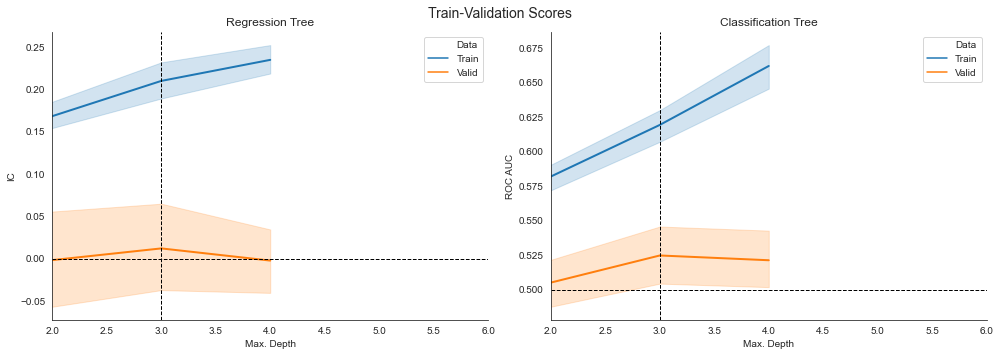

In [84]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))

sns.lineplot(data=reg_cv_data,
             x='Max. Depth', y='IC',
             hue='Data', ci=95,
             ax=axes[0], lw=2)

axes[0].set_title('Regression Tree')
axes[0].axvline(x=reg_valid_scores.mean().idxmax(), ls='--', c='k', lw=1)
axes[0].axhline(y=0, ls='--', c='k', lw=1)

sns.lineplot(data=clf_cv_data,
             x='Max. Depth', y='ROC AUC',
             hue='Data', ci=95,
             ax=axes[1], lw=2)

axes[1].set_title('Classification Tree')
axes[1].axvline(x=clf_valid_scores.mean().idxmax(), ls='--', c='k', lw=1)
axes[1].axhline(y=.5, ls='--', c='k', lw=1)
for ax in axes:
    ax.set_xlim(min(param_grid['max_depth']),
                max(param_grid['max_depth']))

fig.suptitle(f'Train-Validation Scores', fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.91)

### Learning Curves for best models

A learning curve is a useful tool that displays how the validation and training score evolve as the number of training samples evolves.

The purpose of the learning curve is to find out whether and how much the model would benefit from using more data during training. It is also useful to diagnose whether the model's generalization error is more likely driven by bias or variance.

#### Classifier

In [85]:
sizes = np.arange(.1, 1.01, .1)

In [86]:
train_sizes, train_scores, valid_scores = learning_curve(gridsearch_clf.best_estimator_,
                                                         X,
                                                         y_binary,
                                                         train_sizes=sizes,
                                                         cv=cv,
                                                         scoring='roc_auc',
                                                         n_jobs=-1,
                                                         shuffle=True,
                                                         random_state=42)

In [87]:
clf_lc_data = pd.concat([
    pd.melt(pd.DataFrame(train_scores.T, columns=train_sizes),
            var_name='Train Size',
            value_name='ROC AUC').assign(Data='Train'),
    pd.melt(pd.DataFrame(valid_scores.T, columns=train_sizes),
            var_name='Train Size',
            value_name='ROC AUC').assign(Data='Valid')])
clf_lc_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 0 to 199
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Train Size  400 non-null    int64  
 1   ROC AUC     400 non-null    float64
 2   Data        400 non-null    object 
dtypes: float64(1), int64(1), object(1)
memory usage: 12.5+ KB


#### Regression Tree

In [88]:
train_sizes, train_scores, valid_scores = learning_curve(gridsearch_reg.best_estimator_,
                                                         X, y,
                                                         train_sizes=sizes,
                                                         cv=cv,
                                                         scoring=ic,
                                                         n_jobs=-1,
                                                         shuffle=True,
                                                         random_state=42)

In [89]:
reg_lc_data = pd.concat([
    pd.melt(pd.DataFrame(train_scores.T,
                         columns=train_sizes),
            var_name='Train Size',
            value_name='IC').assign(Data='Train'),
    pd.melt(pd.DataFrame(valid_scores.T,
                         columns=train_sizes),
            var_name='Train Size',
            value_name='IC').assign(Data='Valid')])
reg_lc_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 0 to 199
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Train Size  400 non-null    int64  
 1   IC          400 non-null    float64
 2   Data        400 non-null    object 
dtypes: float64(1), int64(1), object(1)
memory usage: 12.5+ KB


#### Compare Learning Curves

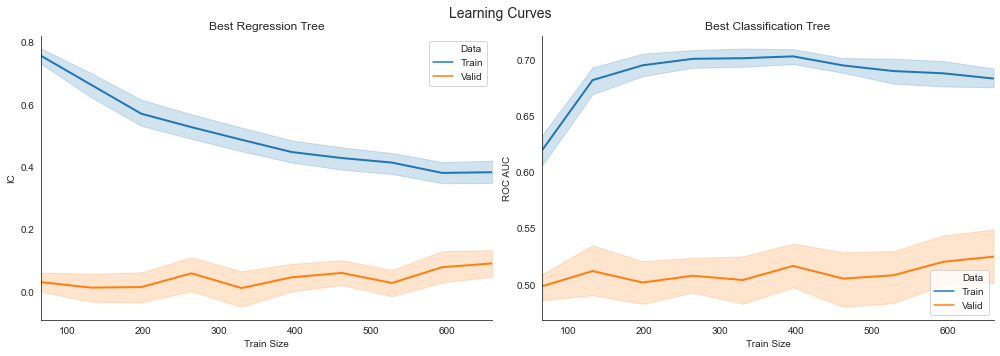

In [90]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))
xmin, xmax = reg_lc_data['Train Size'].min(), reg_lc_data['Train Size'].max()

sns.lineplot(data=reg_lc_data,
             x='Train Size', y='IC',
             hue='Data', ci=95,  ax=axes[0], lw=2)
axes[0].set_title('Best Regression Tree')
axes[0].set_ylabel('IC')

axes[0].xaxis.set_major_formatter(
    FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))

sns.lineplot(data=clf_lc_data,
             x='Train Size',
             y='ROC AUC',
             hue='Data',
             ci=95,
             ax=axes[1],
             lw=2)
axes[1].set_title('Best Classification Tree')
axes[1].set_ylabel('ROC AUC')
axes[1].xaxis.set_major_formatter(
    FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))

for i in [0, 1]:
    axes[i].tick_params(axis='both', which='major', labelsize=10)
    axes[i].tick_params(axis='both', which='minor', labelsize=8)
    axes[i].set_xlim(xmin, xmax)

fig.suptitle('Learning Curves', fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9)

### Feature Importance

Decision trees can not only be visualized to inspect the decision path for a given feature, but also provide a summary measure of the contribution of each feature to the model fit to the training data. 

The feature importance captures how much the splits produced by the feature helped to optimize the model's metric used to evaluate the split quality, which in our case is the Gini Impurity index. 

In [91]:
top_n = 15
labels = X.columns.str.replace('_', ' ').str.upper()
fi_clf = (pd.Series(gridsearch_clf.best_estimator_.feature_importances_, 
                    index=labels).sort_values(ascending=False).iloc[:top_n])
fi_reg = (pd.Series(gridsearch_reg.best_estimator_.feature_importances_, 
                    index=labels).sort_values(ascending=False).iloc[:top_n])

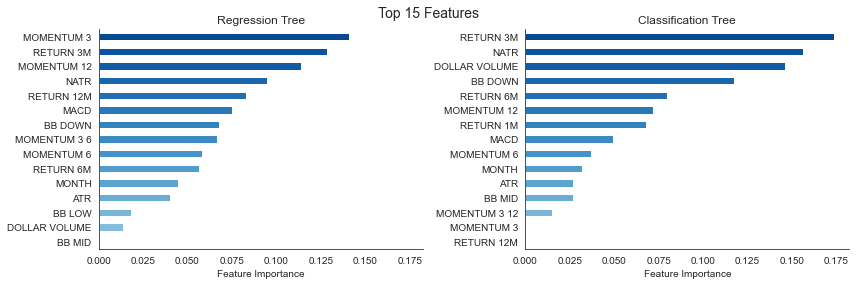

In [92]:
fig, axes= plt.subplots(ncols=2, figsize=(12,4), sharex=True)
color = cm.Blues(np.linspace(.4,.9, top_n))
fi_clf.sort_values().plot.barh(ax=axes[1], title='Classification Tree', color=color)
fi_reg.sort_values().plot.barh(ax=axes[0], title='Regression Tree', color=color)
axes[0].set_xlabel('Feature Importance')
axes[1].set_xlabel('Feature Importance')
fig.suptitle(f'Top {top_n} Features', fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9);